# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [81]:
# Autograd & Numpy
import autograd
import autograd.numpy as np
import numpy.random as rd
import numpy.linalg as alg

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [82]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [83]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [84]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
#g = autograd.grad
#print(g(f,0)(0.0,0.0))

array([0.54030231, 2.        ])

In [85]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [86]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [87]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

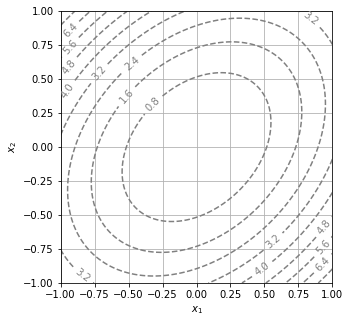

In [88]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [89]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2
grad2 = grad(f2)
grad2(1., 21.)

array([ -880., 36960.])

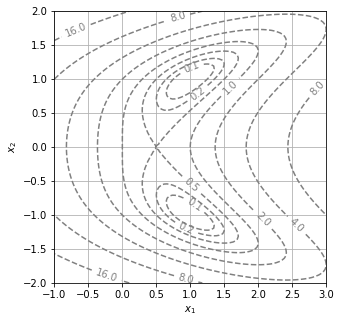

In [90]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [91]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

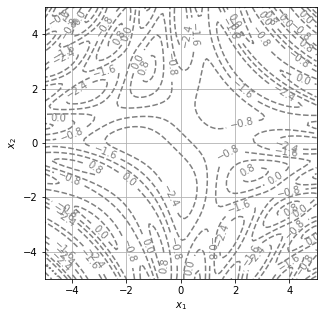

In [92]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

**Réponse**  La fonction Newton est faite pour réaliser un tracé de lignes de niveau par conséquent la précision ne rentre pas un critère majeur. La valeur $\epsilon = 0,01$ peut donc convenir tout à fait et permet un bon compromis précision-rapidité. D'autre part, la condition de convergence en N étape empêche de choisir un epsilon trop petit afin de converger.

In [93]:
N = 1000
eps = 0.001

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [94]:
def Newton(F, x0, y0, eps=eps, N=N):
    jac = J(F)
    for i in range(N):
        J1 = jac(x0, y0)
        #utilisation de la fonction np.linalg.lstsq() pour inverser les matrices par résolution de système 
        x,y=np.linalg.lstsq(J1,-F(x0,y0))[0][0]+x0,np.linalg.lstsq(J1,-F(x0,y0))[0][1]+y0
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")
    return x0, y0


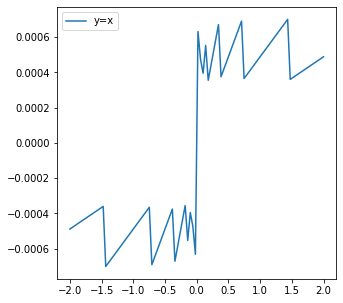

In [95]:
X = np.linspace(-2,2,100)

def F(x,y):
    return np.array([f1(x,y),y-x])
    
Y= np.array([Newton(F,X[i],X[i],eps,N)[0] for i in range(len(X))]) #On prend une des cases de Newton car les deux sont les mêmes avec notre contrainte !
plt.plot(X,Y, label='y=x')
plt.legend()

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

C:\Users\cyril\miniconda3\lib\site-packages\autograd\tracer.py:48: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return f_raw(*args, **kwargs)
No handles with labels found to put in legend.


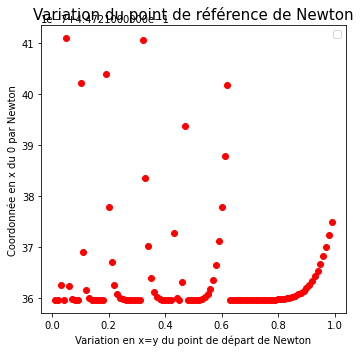

In [96]:
#En appliquant Newton sur [0,1] avec la fonction f1 pour la courbe de niveau c = 0.8

L = []
def F(x,y):
    return np.array([f1(x,y)-0.8,y-x])

for i in range(1,100):
    X = Newton(F, 0.01 * i, 0.01 * i, eps=eps, N=N)
    L.append((0.01 * i,X[0]))
T = np.array(L)
x_min,x_max,y_min,y_max = 0,1,0,1

plt.title('Variation du point de référence de Newton', fontsize=15)
plt.plot(T[:,0],T[:,1],'ro')
plt.ylabel('Coordonnée en x du 0 par Newton')
plt.xlabel('Variation en x=y du point de départ de Newton')
plt.legend()
plt.tight_layout()
plt.show()

On remarque des sauts de la position en 0 pour certaines conditions initiales x0,y0 de l'algorithme de Newton.

C:\Users\cyril\miniconda3\lib\site-packages\autograd\tracer.py:48: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return f_raw(*args, **kwargs)
C:\Users\cyril\miniconda3\lib\site-packages\autograd\tracer.py:48: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return f_raw(*args, **kwargs)


KeyboardInterrupt: 

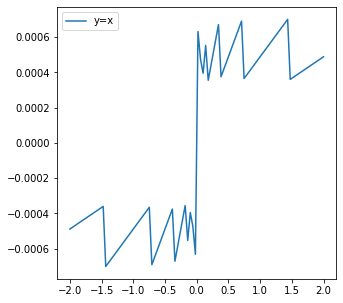

In [97]:
#A noter qu'à chaque fois, selon l'expression de f1, il faut obtenir un couple (x,y) très proche de (0,0).

#Première contrainte, y=x:
def F(x,y):
    return np.array([f1(x,y),y-x])
X= np.linspace(-2,2,100)
Y= np.array([Newton(F,X[i],X[i],eps,N)[0] for i in range(len(X))]) #On prend une des cases de Newton car les deux sont les mêmes avec notre contrainte !
plt.plot(X,Y, label='y=x')
plt.legend()

#Deuxième contrainte, y=5x:
def F2(x,y):
    return np.array([f1(x,y),y-5*x])
X= np.linspace(-2,2,100)
Y= np.array([Newton(F2,X[i],5*X[i],eps,N)[0] for i in range(len(X))]) #On prend ici la première case car on a Y lié à X.
plt.plot(X,Y, label='y=5x')
plt.legend()

#Troisième contrainte, y=x/5:
def F3(x,y):
    return np.array([f1(x,y),y-(x/5)])
X= np.linspace(-2,2,100)
Y= np.array([Newton(F3,X[i],X[i]/5,eps,N)[0] for i in range(len(X))]) #On prend ici la première case car on a Y lié à X.
plt.plot(X,Y, label='y=x/5')
plt.legend()

plt.title('Résultat de Newton avec différentes contraintes')
plt.show()


### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

In [ ]:
def level_curve(f, x0, y0,N=N, delta=0.1, eps=eps):
    c = f(x0, y0)
    
    #Definition du tableau contenant les coordonnées de la courbe de niveau
    points = np.zeros((N,2))
    points[0] = np.array([x0,y0])
        
    grad_f0 = grad(f)(x0,y0)
    
    for i in range(1, N):
        
        def F(x,y):
            return np.array([f(x,y)-c,delta - np.sqrt((x-x0)**2 + (y-y0)**2)])
        
        grad_f0 = grad(f)(x0,y0)
        
        #normalisation du gradient
        vect_grad = grad_f0 / np.sqrt(np.sum(grad_f0 ** 2))
        #détermination du vecteur tangent à la courbe à partir du gradient
        tangente = np.array([vect_grad[1],-vect_grad[0]])  
        #détermination des nouvelles coordnnées à partir de la méthode de Newton    
        x1,y1 = (x0, y0) + delta * tangente
        points[i] = Newton (F, x1, y1, eps, N)
        x0, y0 = points[i]
    
    #la transposé permet d'avoir un objet de dimension similaire à celle d'une liste
    return np.transpose(points)

In [ ]:
T = level_curve(f1, 0.51,0.)
X = T[0,:]
Y = T[1,:]
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)
plt.plot(X,Y,'o--',color = 'c', label= 'N = '+str(N)+' itération')
plt.title("level_curve( f1 )")
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.tight_layout()

plt.show()

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

In [ ]:
# La boucle s'arrete lorsque le point obtenu (x1,y1) est dans la boule centrée en (x0,y0) et de rayon r = delta

def level_curve_new(f, x0, y0, delta=0.01, N=N, eps=eps):
    c = f(x0, y0)
    xi,yi = x0,y0

    points = np.zeros((N,2))
    points[0] = np.array([x0,y0])
           
    for i in range (1, N):

        def F(x,y):
            return np.array([f(x,y)-c,delta - np.sqrt((x-x0)**2 + (y-y0)**2)])
        
        grad_f0 = grad(f)(x0,y0)
        #normalisation du gradient
        vect_grad = grad_f0 / np.sqrt(np.sum(grad_f0 ** 2))
        #détermination du vecteur tangent à la courbe à partir du gradient
        tangente = np.array([vect_grad[1],-vect_grad[0]])      
        x1,y1 = (x0, y0) + delta * tangente
        #détermination des nouvelles coordnnées à partir de la méthode de Newton 
        x1,y1 = Newton (F, x1, y1, eps, N)
        #utilisation du if afin de determiner le moment où la courbe de niveau boucle sur elle-même
        if alg.norm(np.array([x1,y1])-np.array([xi,yi])) < delta and i != 1: # vérification que la distance du nouveau point par rapport au premier est inférieur à delta et un nombre suffisant d'itération a été réalisé 
            points[i] = points[0]
            return np.transpose(points)[:,0:i+1]
        else :
            points[i] = x1,y1
            x0, y0 = points[i]
    
    #la transposé permet d'avoir un objet de dimension similaire à celle d'une liste
    return np.transpose(points)

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

In [ ]:
T = level_curve_new(f1, 0.1,0.1)
X = T[0,:]
Y = T[1,:]
plt.plot(X,Y,'.',color = 'c', label= 'N = '+str(N)+' itération')
plt.title("level_curve_new ( f1 )")
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.tight_layout()
plt.show()

On remarque aucune superposition de points de la courbe de niveau.

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

In [ ]:
def area_squares(f,c,h):
    #point arbitraire proche du cercle mais à l'extérieur de celui-ci
    xi,yi = 0.,1.2
    
    def F(x,y):
        return np.array([f(x,y)-c,x-y])
    x0,y0 = Newton(F, xi, yi)

    #determination des points formant la frontière de l'ensemble de sous-niveau de f
    tab = level_curve_new(f, x0, y0)
    
    x=tab[0,:]
    y=tab[1,:]
    
    #determination des indices extrêmales de l'ensemble
    xM=max(x)
    yM=max(y)
    xm=min(x)
    ym=min(y)
    
    #nombre de petits carrés formant un côté du grand carré
    H = int(max(xM-xm,yM-ym)/h)+1

    compteur=0
    for i in range(H):
        for j in range(H):
            #on se place au centre de chaque petit carré et on vérifie si il appartient bien à l'ensemble de sous-niveau de f
            if f(xm+h*(i-1/2),ym+h*(j-1/2)) <= c:
                compteur += 1
    Ah = compteur*(h**2)
    
    return Ah   

In [ ]:
def disque_unite(x,y):
    return(x**2+y**2)

#comparer la valeur obtenue à pi, valeur exacte de l'aire du disque unité pour différentes valeurs de pas h 
H=np.linspace(1,3,10)
H=10**(-H)

A_Ah=[]
A_Ah=[abs(np.pi-area_squares(disque_unite,c=1,h=k)) for k in H]

#affichage de la courbe de l'erreur en fonction de h en échelle log-log
plt.plot(np.log10(H),np.log10(A_Ah),'o--',label='log(|Ah-A|) = f(h)')
plt.title("Comportement de Ah-A quand h tend vers 0")
plt.xlabel('log(h)')
plt.ylabel('log(|Ah-A|)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#Comparaison de la valeur obtenue à pi

print('Aire obtenue par la méthode des carrés = '+str(area_squares(disque_unite,c=1,h=0.01))+' ≈ pi')
print('On a bien une erreur qui diminue lorsque le pas diminue')

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


In [ ]:
#Nouvelle version du code permettant d'obtenir un encadrement par la méthode des carrés

def area_squares_encadrement(f,c,h):
    #point arbitraire proche du cercle mais à l'extérieur de celui-ci
    xi,yi = 0.,1.2
    
    def F(x,y):
        return np.array([f(x,y)-c,x-y])
    x0,y0 = Newton(F, xi, yi)

    #determination des points formant la frontière de l'ensemble de sous-niveau de f
    tab = level_curve_new(f, x0, y0)
    
    x=tab[0,:]
    y=tab[1,:]
    
    #determination des indices extrêmales de l'ensemble
    xM=max(x)
    yM=max(y)
    xm=min(x)
    ym=min(y)
    
    #nombre de petits carrés formant un côté du grand carré
    H = int(max(xM-xm,yM-ym)/h)+1

    compteur_min,compteur_max=0,0
    
    ##
    carre_in=[]
    carre_lim=[]

    for i in range(H):
        for j in range(H):
            sommets_carre = []
            #sommets_carre = (bas_gauche, bas_droit, haut_gauche, haut_droit)
            sommets_carre = ((xm+h*i,ym+h*j), (xm+h*(i+1),ym+h*j), (xm+h*i,ym+h*(j+1)), (xm+h*(i+1),ym+h*(j+1)))
                        
            Booleen_min, Booleen_max = True, False
            
            #Verification que tous les sommets du carré sont bien dans l'ensemble à mesurer (critère min)
            for k in sommets_carre :
                if f(k[0],k[1]) > c :
                    Booleen_min = False
                    break
            
            #Verification qu'au moins un sommet du carré est dans l'ensemble à mesurer (critère max)
            for k in sommets_carre :
                if f(k[0],k[1]) <= c :
                    Booleen_max = True
                    break

            if Booleen_min == True :
                carre_in.append([xm+h*(i+1/2),ym+h*(j+1/2)])
                compteur_min += 1 

            if Booleen_max == True :
                if not Booleen_min :
                    carre_lim.append([xm+h*(i+1/2),ym+h*(j+1/2)])
                compteur_max += 1

    Ah_min = compteur_min*(h**2)
    Ah_max = compteur_max*(h**2)
    
    return Ah_min,Ah_max,carre_in,carre_lim

In [ ]:

#comparer la valeur obtenue à pi, valeur exacte de l'aire du disque unité
A=area_squares_encadrement(disque_unite,c=1,h=0.01)
print('Valeurs minimale et Maximale = '+str(A[0])+' et '+str(A[1]))
#on a bien : Ah_min = 3.138 < np.pi < 3.145

#Affichage du quadrillage, les carrés sont comptés pour la minoration et les rouges sont ajoutés pour obtenir une majoration
X_in=[k[0] for k in A[2]]
Y_in=[k[1] for k in A[2]]
X_lim=[k[0] for k in A[3]]
Y_lim=[k[1] for k in A[3]]

plt.plot(X_in,Y_in,'g,',label='Aire Minimale')
plt.plot(X_lim,Y_lim,'r,',label='Aire Maximale')
plt.title("Comparaison A_min et A_max")
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.tight_layout()
plt.show()

La limite rouge correspond à la frontière min / max.

**Réponse** Pour obtenir un encardement à $10^{-2}$ près, on utilise la même méthode que area_squares mais à la place de vérifier que le centre de chaque petit carré appartient à l'ensemble on vérifie les sommets de chaque petit carré ($h^{2}$).
Si tout les sommets du petit carré ($h^{2}$) appartiennent à l'ensemble, alors il vérifie le critère minimum et on prend en compte son aire pour minorer l'aire réelle.
D'autres part, si au minimum un sommet du petit carré ($h^{2}$) appartient à l'ensemble, alors il vérifie le critère maximum et on prend en compte son aire pour majorer l'aire réelle.

On retrouve bien: $$ Ah_{min} = 3.137 < \pi < 3.145 $$


## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  


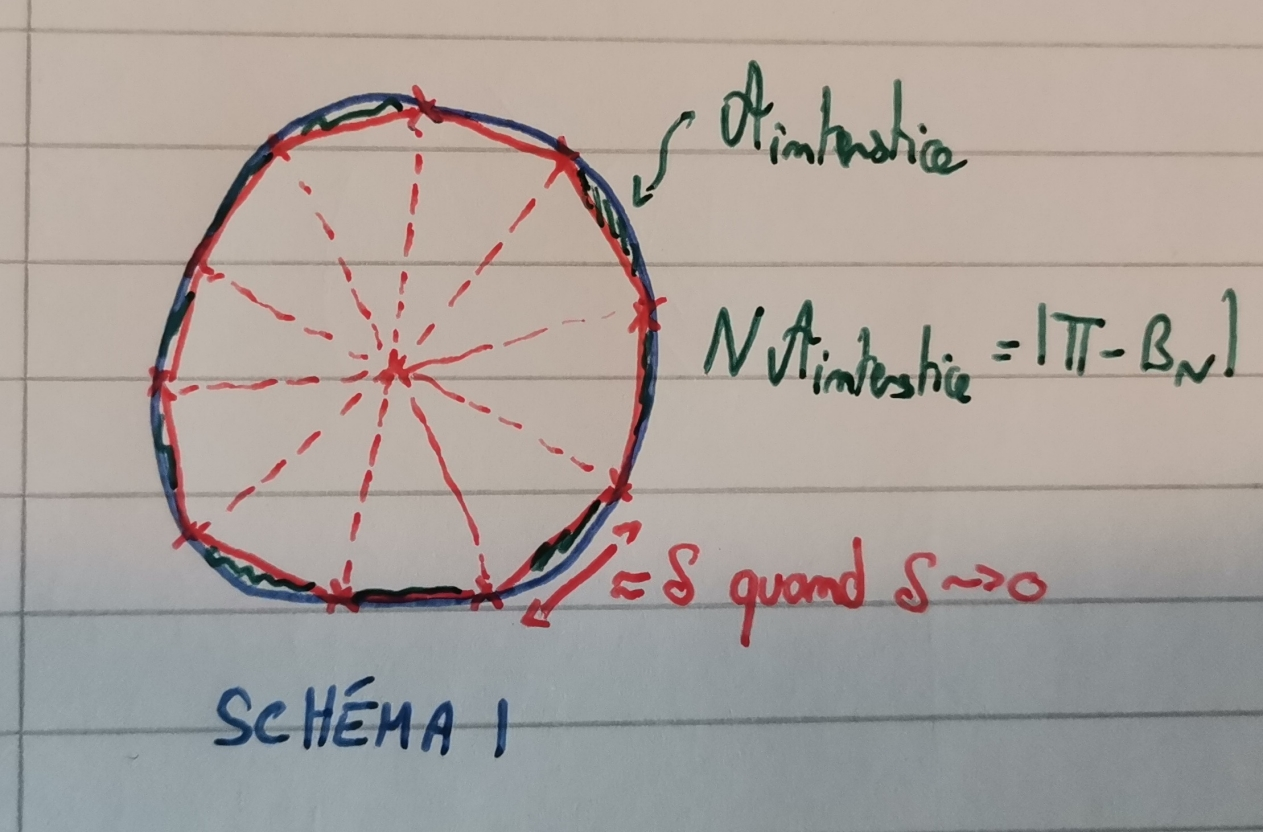


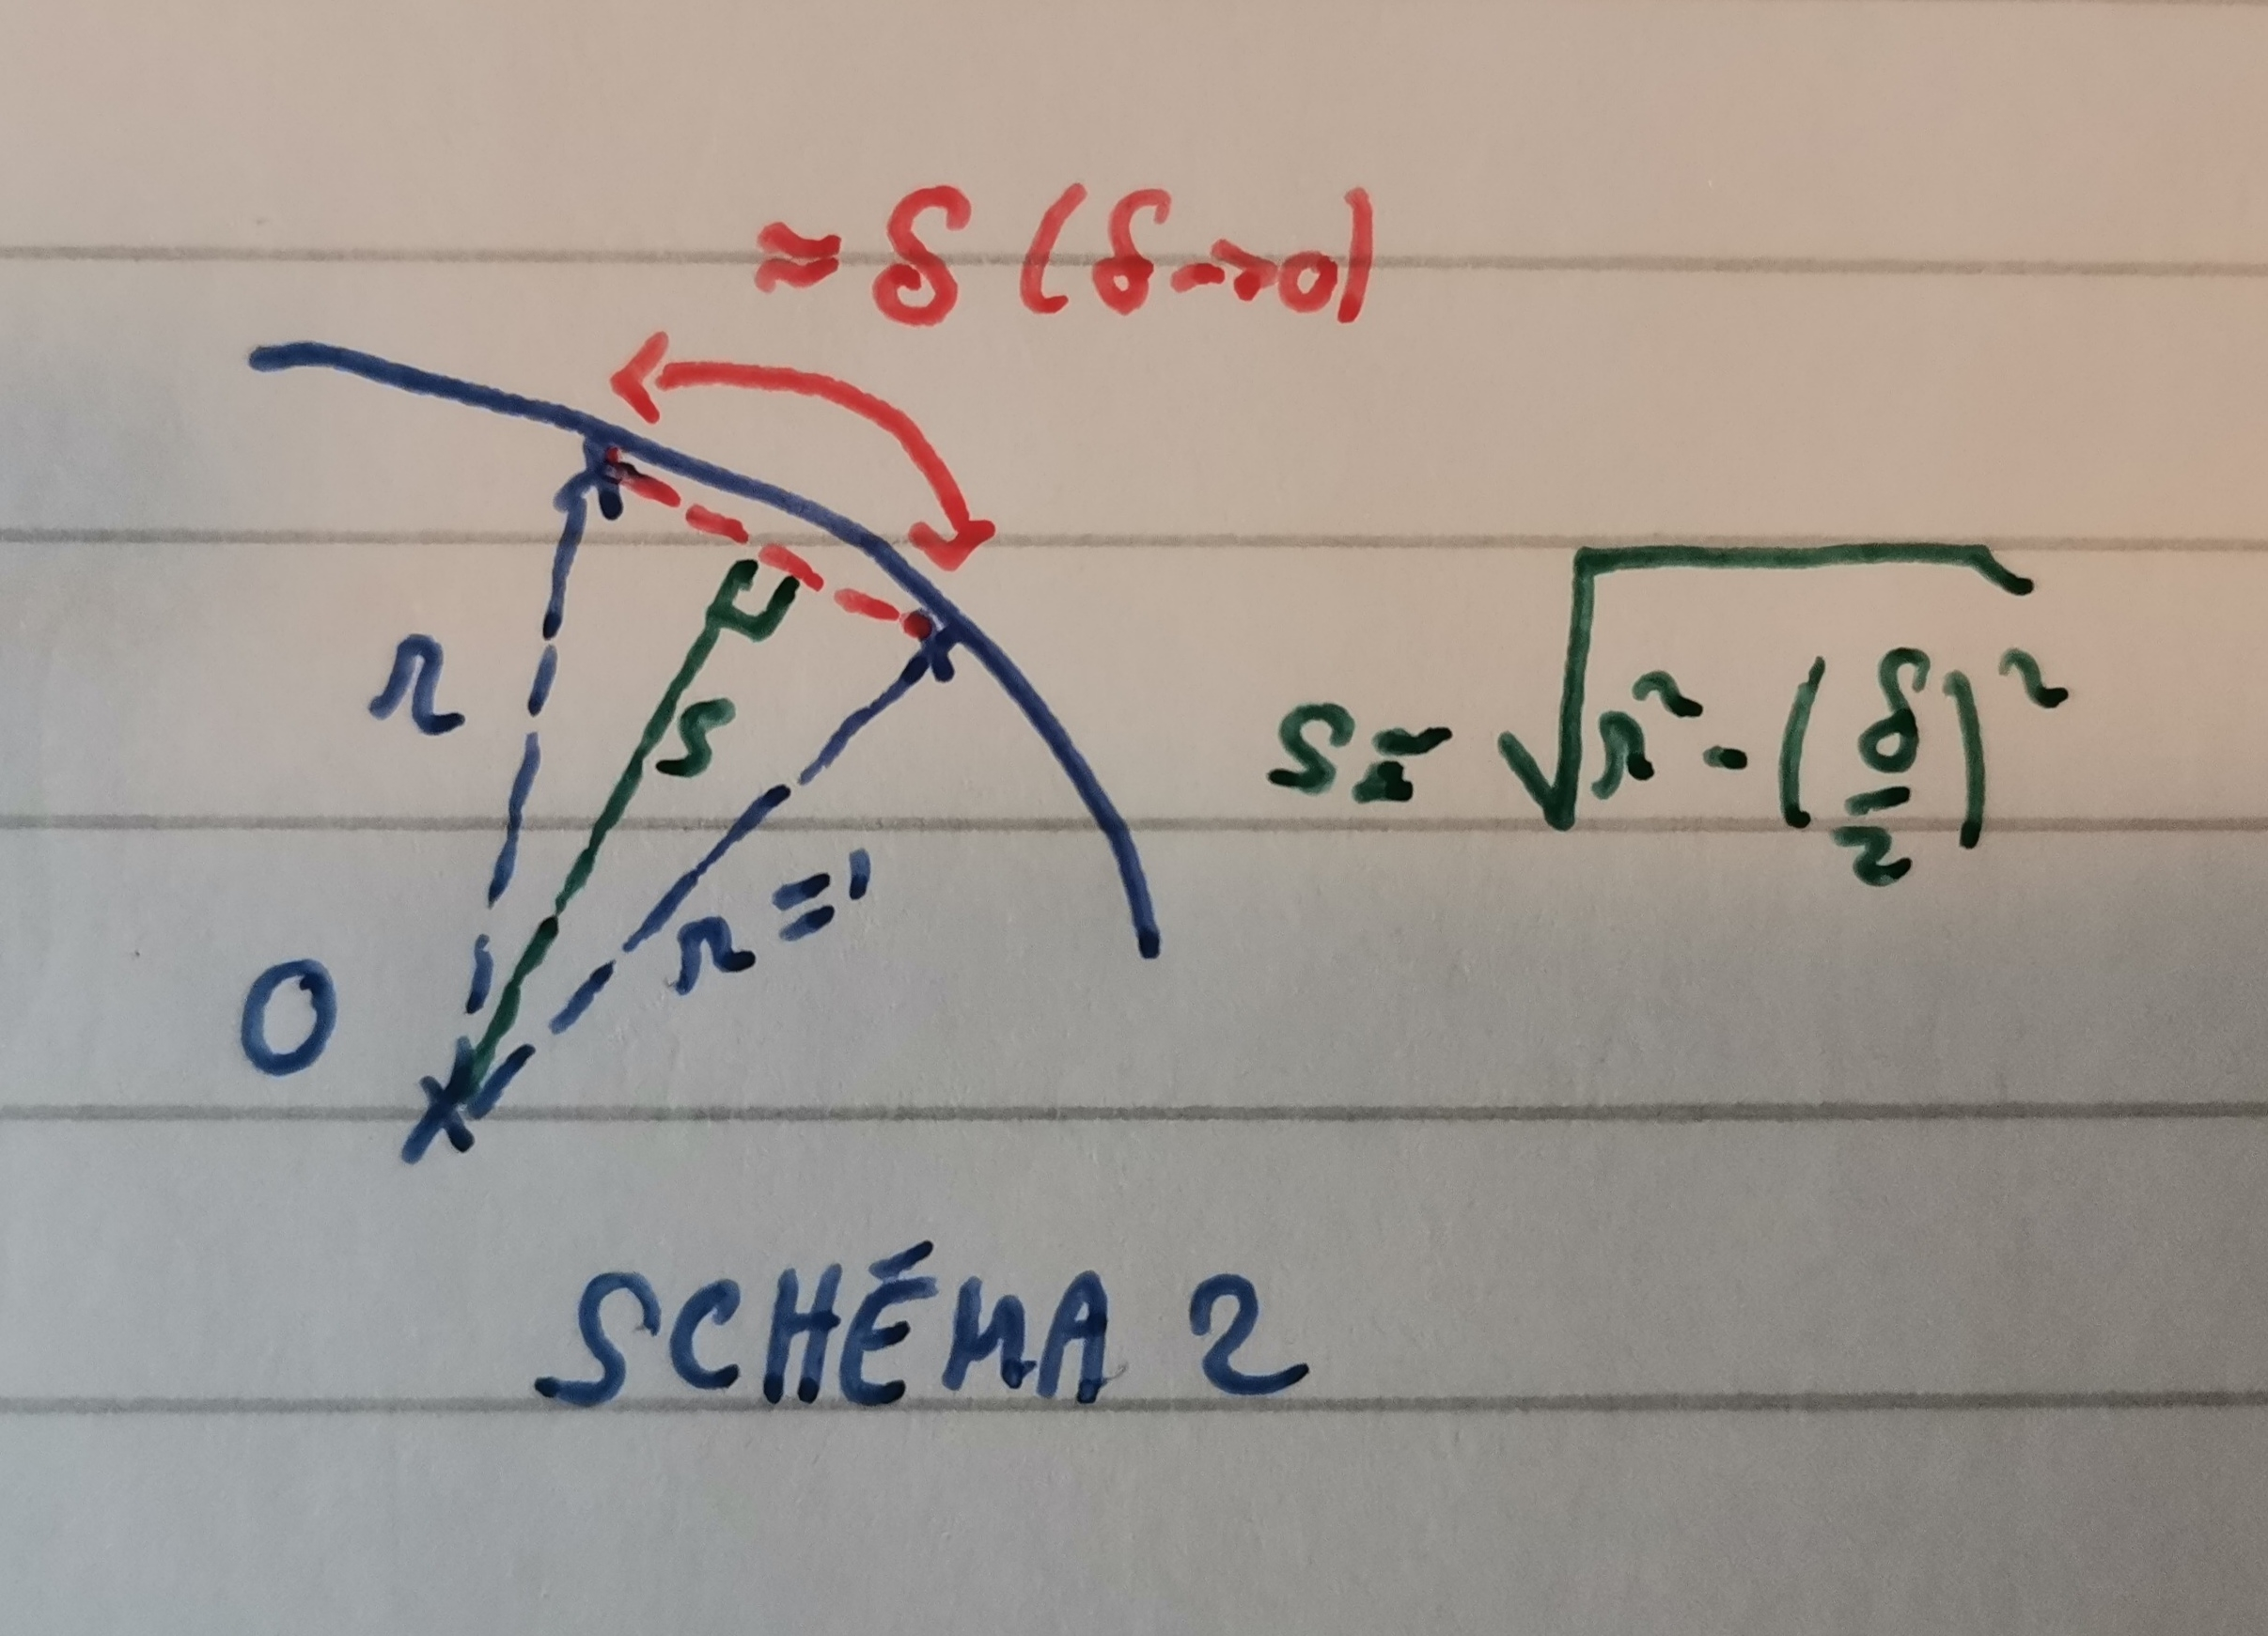

**Réponse** On peut observer que $\forall p \in Intérieur(K)$, $\exists  \delta>0: p \in Intérieur($Aire des triangles)
Alors, comme nous travaillons sur le disque unité, nous pouvons nous ramener au centre du disque car aucune propriété ne va changer, ce sera plus simple pour les calculs. En effet, c'est assez visuel, nous pouvons le noter sur la figure 1. 
De plus, nous pouvons lier $N$ et $\delta$, car nous pouvons remarquer que $N=\lfloor\frac{2\pi}{\delta}\rfloor$ sur ce cercle unité. Lorsque $\delta$ est petit, on peut même considérer: $N\delta\approx2\pi$.
Alors selon le schéma 1, on remarque bien que $\mid \pi - B_{N} \mid = \mid \pi - B_{\delta} \mid = NA_{interstice}$, où $A_{interstice}$ représente l'aire d'un interstice.
En travaillant sur le schéma 2, on déduit alors que: $A_{vraie} = \frac{r^{2}\delta}{2} = \frac{\delta}{2}$ et de même $A_{triangle} = \frac{\delta}{2}\sqrt{r^{2} - \frac{\delta}{2}^{2}} \approx \frac{\delta}{2}(1 - \frac{\delta^{2}}{4})$\
Donc $A_{interstice} = \frac{\delta^{3}}{8}$ et en considérant $N \approx \frac{2\pi}{\delta}$, on obtient finalement:
$$ \mid \pi - B_{\delta} \mid = \frac{\pi \delta^{2}}{4} $$
Dans la pratique, on observe qu'un coefficient $\frac{\pi}{6}$ convient mieux.


In [ ]:
Z = []
T = np.linspace(0.0001, 0.1, 100)
for delta in T:
    Z.append((np.pi/8)*(delta**2))
plt.plot(T, Z)
plt.title('Ecart entre $\pi$ et $B_N$ lorsque $\delta$ tend vers 0')
plt.xlabel('$\delta$')
plt.show()


**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

**Réponse** On va tout d'abord vérifier numériquement en calculant l'aire depuis un point p extérieur à K, grâce à un algorithme que voici: 

In [ ]:
def dist(x,y):
    return np.sqrt((x[0] - y[0])**2 + (x[1] - y[1])**2)

def area_triangles(x, y):
    A = 0
    p = ( 6, 4 )
    for i in range(len(x) - 1):
        a, b, c = dist(p, [x[i], y[i]]), dist(p, [x[i + 1], y[i + 1]]), dist([x[i], y[i]], [x[i + 1], y[i + 1]])
        s = (a + b + c)/2
        V_p_z = complex(x[i] - p[0], y[i] - p[1])
        V_p_z_1 = complex(x[i + 1] - p[0], y[i + 1] - p[1])
        M = np.array([[x[i]-p[0], y[i] - p[1]],[x[i + 1]- p[0], y[i + 1]-p[1]]])
        A += -0.5*np.linalg.det(M)
    return A

In [ ]:
def fi(x,y):
    return x**2 + y**2

In [ ]:
def f19(x):
    return np.pi*(x**2)/6
Z = []
X = []
T = np.linspace(0.01, 0.1, 10)
for delta in T:
    S = level_curve_new(fi, 1., 0., delta, N=1000, eps=eps)
    x1 = [S[0][i] for i in range(len(S[0]))]
    y1 = [S[1][i] for i in range(len(S[0]))]
    Z.append(np.abs(np.pi - area_triangles(x1, y1)))
    X.append(f19(delta))
    
plt.figure(1,figsize=(10,12))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1.5,
                          top = 0.9, wspace = 0.5, hspace = 0)
plt.subplot(1,2,1)
F0=level_curve_new(fi, 1.,0.)
X0=F0[0,:]
Y0=F0[1,:]
plt.plot(X0,Y0, label='Disque')
plt.axis('equal')
X3 =[6]
Y3 = [4]
plt.plot(X3, Y3, 'ro',label='Point p')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)     
plt.plot(T,Z, label='$\mid\pi - B_{\delta}\mid$')
plt.plot(T, X, label='$\pi\delta^{2}/4$')
plt.title('Ecart entre $\pi$ et $B_N$ lorsque $\delta$ tend vers 0')
plt.xlabel('$\delta$')
plt.legend()
plt.show()



On observe alors que l'aire calculée correspond bien à ce que nous voulions trouver.
En effet, cela s'explique par un phénomène de "télescopage": on peut tout d'abord diviser en deux groupes distincts les aires $A_i = A(p, z_i, z_{i+1})$, selon qu'elles soient positives ou négatives. Ensuite, on remarque une compensation: les aires négatives vont soustraire les surfaces en dehors de $K$, ne touchant presque pas (pour un $\delta$ proche de 0) notre ensemble $K$. Or les aires positives vont englober $K$ et aussi prendre en compte les aires en dehors de $K$, qui sont en réalité les aires négatives. En faisant la somme des $A_i$, on retrouve alors notre aire $A$ souhaitée, qui est celle de l'ensemble $K$.


**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

**Réponse** Nous allons procéder de la même manière que précedemment, en testant tout d'abord numériquement notre hypothèse:



In [ ]:
def f10(x,y):
    return (x - 4)**2 + (y - 4)**2

def f20(x,y):
    return (x - 5)**2 + (y - 6)**2

Z = []
T = np.linspace(0.02, 0.1, 10)
for delta in T:
    S10 = level_curve_new(f10, 5., 4., delta, N=1000, eps=eps)
    x10 = [S10[0][i] for i in range(len(S10[0]) - 1)]
    y10 = [S10[1][i] for i in range(len(S10[0]) - 1)]

    S20 = level_curve_new(f20, 6., 6., delta, N=1000, eps=eps)
    x20 = [S20[0][i] for i in range(len(S20[0]))]
    y20 = [S20[1][i] for i in range(len(S20[0]))]

    xnew = x10 + x20 + [x10[0]]
    ynew = y10 + y20 + [y10[0]]
    Z.append(np.abs(2*np.pi - area_triangles(xnew, ynew)))

    
plt.figure(1,figsize=(10,12))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1.5,
                          top = 0.9, wspace = 0.5, hspace = 0)
plt.subplot(1,2,1)
F1=level_curve_new(f10, 5., 4.)
X1=F1[0,:]
Y1=F1[1,:]
plt.plot(X1,Y1, label='Disque 1')
plt.axis('equal')
F2=level_curve_new(f20, 6., 6.)
X2=F2[0,:]
Y2=F2[1,:]
plt.plot(X2,Y2, label='Disque 2')
X3 =[6]
Y3 = [4]
plt.plot(X3, Y3, 'ro', label='Point p')
plt.legend()

plt.grid()
plt.subplot(1, 2, 2)
plt.plot(T,Z)
plt.title('Ecart entre $2\pi$ et $B_N$ lorsque $\delta$ tend vers 0')
plt.xlabel('$\delta$')
plt.show()

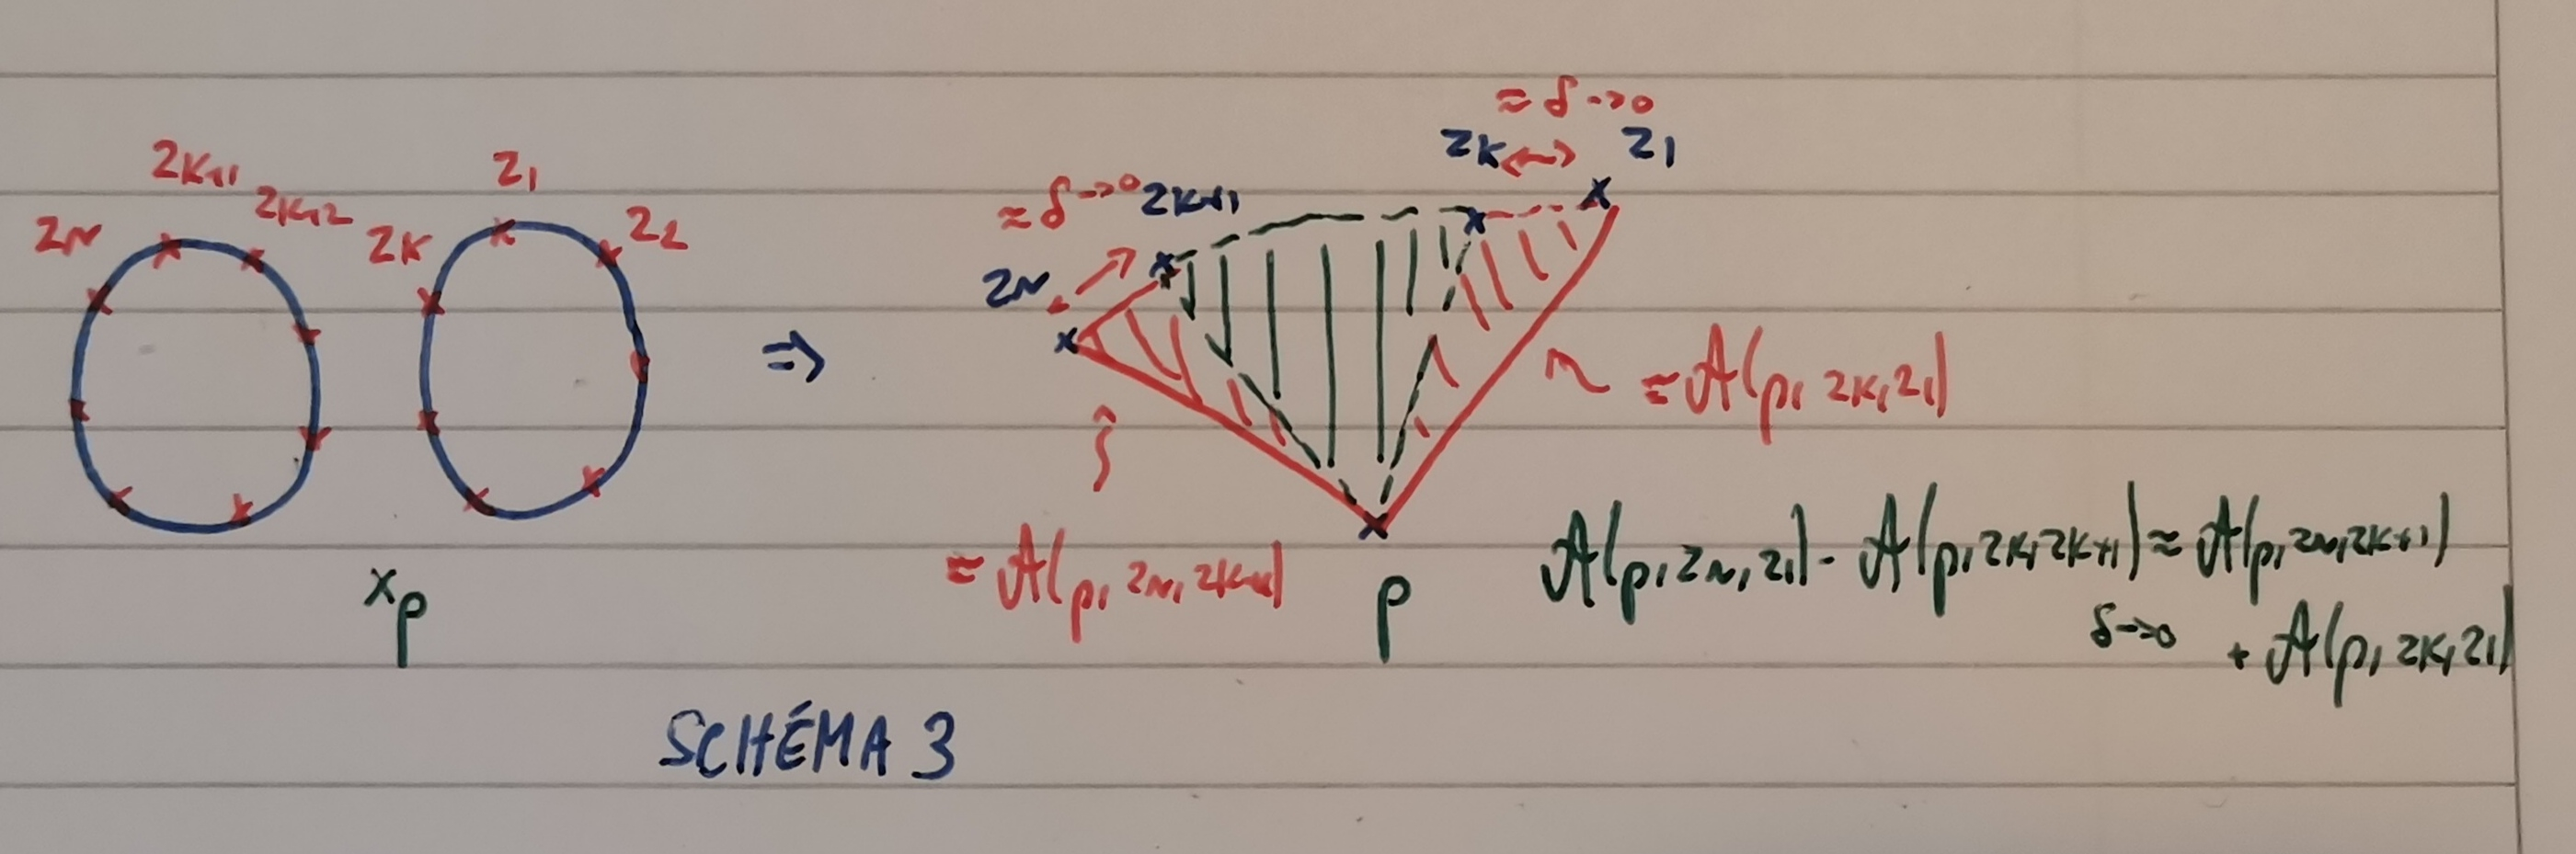

En réalité, en se plaçant sur un $K$ réunion de deux disques disjoints, les seuls cas limites vont se situer au niveau des "frontières", puisque nous avons vu à la question précédente que se placer sur un $p$ extérieur à l'ensemble ne posait pas de problème. \
En suivant les notations du schéma 3, ce sont donc $A(p, z_k, z_{k+1})$ et $A(p, z_N, z_1)$ qui vont nous intéresser.\
Or lorsque qu'on soustrait la première aire à la deuxième, on remarque qu'il nous reste précisément $A(p, z_N, z_{k+1}) + A(p, z_k, z_1)$ !\
Ainsi, les conditions aux bornes sont respectées et nous obtenons donc précisément la somme des aires de chaque disque en réarrangeant notre calcul, ce qui valide notre hypothèse.


**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [ ]:
def area_triangles(x, y):
    A = 0
    p = ( 6, 4 )
    for i in range(len(x) - 1):
        a, b, c = dist(p, [x[i], y[i]]), dist(p, [x[i + 1], y[i + 1]]), dist([x[i], y[i]], [x[i + 1], y[i + 1]])
        s = (a + b + c)/2
        V_p_z = complex(x[i] - p[0], y[i] - p[1])
        V_p_z_1 = complex(x[i + 1] - p[0], y[i + 1] - p[1])
        M = np.array([[x[i]-p[0], y[i] - p[1]],[x[i + 1]- p[0], y[i + 1]-p[1]]])
        A += -0.5*np.linalg.det(M)
    return A

On a utilisé précédemment cette même fonction pour nos ensembles de sous-niveau considérés précédemment, et cela a bien fonctionné pour décrire les aires.
Si on compare pour une même fonction, le cercle unité centré en 0 par exemple:

In [ ]:
Z = []
X = []
T = np.linspace(0.01, 0.1, 10)
for delta in T:
    S = level_curve_new(fi, 1., 0., delta, N=1000, eps=eps)
    x1 = [S[0][i] for i in range(len(S[0]))]
    y1 = [S[1][i] for i in range(len(S[0]))]
    Z.append(area_triangles(x1, y1))
    X.append(area_squares(fi,1.,delta))
    
plt.plot(T,Z, label='Méthode des triangles')
plt.plot(T,X, label='Méthode des carrés')
plt.legend()
plt.show()

On remarque alors que la méthode des triangles semble avoir une convergence plus rapide et plus précise, même avec des pas plus grands. En effet, cela peut s'expliquer en effectuant un parallèle avec la méthode numérique d'intégration. Lorsque nous appliquons la méthode des carrés, même avec un pas faible, les carrés ne vont pas suivre le profil de $K$ notre ensemble de niveau. Or avec la méthode des triangles, on va déjà se rapprocher du profil de $K$. C'est le même principe avec la méthode des rectangles et celle des trapèzes: en effet, on va gagner en précision en essayant de suivre le profil. Cependant, un défaut de la méthode des triangles est qu'elle est plutôt lente (peut-être aurions-nous du utiliser des fonctions de numpy rendant notre fonction plus efficace).

